# Tensor Field Network Elastic Tensor Predictions 

Nima Leclerc (nleclerc@seas.upenn.edu) and Abhinav Ramkumar (rabhinav@seas.upenn.edu). School of Engineering and Applied Science, University of Pennsylvania. 

In [173]:
import torch
torch.set_default_dtype(torch.float64)
import torch_geometric as tg
from torch_scatter import scatter_add, scatter_mean
import e3nn
from e3nn import rs, o3
from e3nn.networks import GatedConvParityNetwork
from e3nn.tensor import CartesianTensor
from e3nn.point.message_passing import Convolution
from e3nn.point.data_helpers import DataPeriodicNeighbors
import pymatgen
from pymatgen.ext.matproj import MPRester
import numpy as np

# I. Data Query and Preprocessing 

Here, we will query 22 elasticity tensors from the Materials Project Database. These all belong to different phases of SiO$_{2}$ (constant composition, but these phases exist at various pressures and temperatures across the Si-O phase diagram). [Note: Error below originated while running this codeblock on 12/15 when Materials Project database was shut down. Data previously queried]. 

In [141]:
## Perform Data Query for Compounds with SiO2 composition  
with MPRester("jSMwykbKMFam0seE") as m:
    # Structure for material id
    dataset_all = m.get_data("SiO2", prop="elasticity")
dataset_contains_elasticity = [] ## all SiO2 compounds with availible elasticity tensors 
for item in dataset_all: 
    if item["elasticity"]:
        dataset_contains_elasticity.append(item)
    else: 
        continue 
## Seperate dataset into material ID, elasticity tensor, structure         
dataset_material_ids = [] 
dataset_elasticity_tensors = [] 
dataset_structures  = [] 
for item in dataset_contains_elasticity: 
    dataset_material_ids.append(item['material_id'])
    dataset_elasticity_tensors.append(np.array(dataset_contains_elasticity[0]['elasticity']['elastic_tensor_original']))
    with MPRester("jSMwykbKMFam0seE") as m:
        struct = m.get_structure_by_material_id(item['material_id']) 
        dataset_structures.append(struct)
        

MPRestError: REST query returned with error status code 503. Content: b'The Materials Project API is offline until Dec 17th 5pm USA/Pacific due to a power upgrade at the National Energy Research Scientific Computing Center (NERSC) that hosts our infrastructure.'

Elasticity tensors queried from Materials Project originally in Voigt notation (engineering notation). Function below implemented to convert from Voigt to Cartesien notation (the format that's read in by the neural network).  

In [170]:
## Helper function to convert elasticity tensors from Voigt to cartesian notation
def voigt_to_cartesian(voigt):
    voigt_map = {(1, 1): 1, (2, 2): 2, (3, 3): 3, (2, 3): 4, (1, 3): 5, (1, 2): 6}
    cartesian = np.zeros((3, 3, 3, 3), dtype=np.float64)
    for i in range(1, 3+1):
        for j in range(1, 3+1):
            for k in range(1, 3+1):
                for n in range(1, 3+1):
                    p = (i, j) if i <= j else (j, i)
                    s = (k, n) if k <= n else (n, k)
                    cartesian[i-1, j-1, k-1, n-1] = voigt[voigt_map[s]-1, voigt_map[p]-1]
    return cartesian 

Peform necessary conversions from Voight to Cartesian. $Q$ matrices then obtained to convert Cartesian tensors to an irreduciable form. Irreduciable formed obtaiend by acting $Q$ on the cartesian tensor. This converts an 81 element tensor to a 21 element vector by leveraging permutation and rotational symmetry. 

In [198]:
## Convert elasticity tensors from Voigt to Cartesian notation 
dataset_elasticity_tensors_cart = [] 
for item in dataset_elasticity_tensors:
    temp = voigt_to_cartesian(item)
    dataset_elasticity_tensors_cart.append(torch.from_numpy(np.array(temp)))

## Get Q matrices 
Q_matrices_elastic = [] #Representations tensors, Q   
Rs_outs = [] # Representations of elasticity tensors 
for item in dataset_elasticity_tensors_cart:
    cart = CartesianTensor(item, 'ijkl=jikl=klij')
    Rs_out, Q = cart.to_irrep_transformation() 
    Q_matrices_elastic.append(Q)
    Rs_outs.append(Rs_out)   
    
## Convert to Irrep
dataset_elasticity_tensors_cart_irrep = [] 
for i in range(len(dataset_elasticity_tensors_cart)):
    Q = Q_matrices_elastic[i]
    tens = dataset_elasticity_tensors_cart[i]
    irrep = torch.einsum('ix,x->i', Q, tens.reshape(-1))
    dataset_elasticity_tensors_cart_irrep.append(torch.reshape(irrep,(1, 21) )) 

Dataset containing atomic coordinates for each SiO$_{2}$ phase, converted to a structural representation to be read in by the network.

In [179]:
## Obtain input dataset (structural input)
struct_data = []
Rs_in = [(2, 0, 1)]
R_cut = 6.0
for item in dataset_structures: 
    dat = DataPeriodicNeighbors(torch.ones(len(item), 1), Rs_in, item.cart_coords, item.lattice, R_cut)
    struct_data.append(dat) 

Training set now established, containing (x_train_sio2, y_train_sio2). x_train_sio2 contains atomic represesntations for each SiO$_{2}$ phase and y_train_sio2 contains set of elasticity tensors for each phase in an irreduciable form. 

In [241]:
## Establish training set
x_train_sio2 = struct_data
y_train_sio2 = dataset_elasticity_tensors_cart_irrep  

# II. Setup Network Architecture

We use the e3nn package to implement a Gated Convolution Parity Network here. Our specific architecture contains 4 layers, taking in an atomic representation as an input and outputs a representation of a fourth-rank tensor. The radial basis function was used as the radial component of the point convolution. The network architecture closely follows that in the schematic below: 
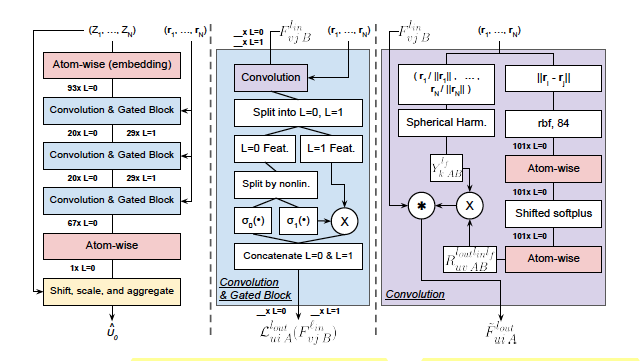

In [ ]:
Rs_out, Q = dataset_elasticity_tensors_cart_obj[0].to_irrep_transformation() #Obtain output representations
N_atom_types = 1 # 2 atom types: Si and O 
Rs_in = [(N_atom_types, 0, 1)] # Input tensor representation 
Rs_out = Rs_out  # Output tensor representation 
r_max = 6.0 # Radial cutoff in Ang. 

model_kwargs = { #Network inputs 
    'convolution': Convolution,
    'Rs_in': Rs_in,  # one scalar and one L=2, both with even parity
    'Rs_out': Rs_out,
    'mul': 4, 'lmax': 4, 'layers': 3,
    'max_radius': r_max,  # from dataset
    'number_of_basis': 10,
} ##changed Lmax from 2 to 4

class AggregateAtoms(torch.nn.Module): # Network object 
    def __init__(self, network):
        super().__init__()
        self.network = network
        
    def forward(self, input, *args, **kwargs):
        N = input.shape[0]
        if 'batch' in kwargs:
            batch = kwargs['batch']
        else:
            batch = torch.zeros(N).to(torch.int64)
        output = self.network(input, *args, **kwargs)
        output = scatter_mean(output, batch, dim=0)
        return output
    
network = GatedConvParityNetwork(**model_kwargs)
model = AggregateAtoms(network)
n_norm = 50  ## normalization set to 50  

# III. Train architecture

First we the model to overfit on a single SiO$_{2}$ elasticity tensor. We train this for 300 epochs, using the Adam optimizer, and learning rate of 0.01. [Eventually cut short to 171 epochs for convergence was achievced]

In [290]:
## Training module 
def main():
    outs = [] # output tensors 
    loss_values = []  #loss values 
    network = GatedConvParityNetwork(**model_kwargs) # define network 
    model = AggregateAtoms(network) #define model 
    torch.set_default_dtype(torch.float64)
    x_train = x_train_sio2 # atomic representations 
    y_train = y_train_sio2 # elaticity tensors 
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  #Adam optimizer 
    loss_func = torch.nn.MSELoss()
    i = 0  
    for step in range(300): #Train for 300 epochs 
        out = model(x_train[0].x, x_train[0].edge_index, x_train[0].edge_attr, n_norm=n_norm)
        outs.append(out.detach())
        loss = loss_func(out, y_train[0])
        loss_values.append(loss.item())
        print("iter: " +str(i)+ " loss: " +str(loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1 
    return model, outs, loss_values

In [291]:
if __name__ == '__main__':
    model, outs,losses =  main()

iter: 0 loss: 2657.421041919695
iter: 1 loss: 1782.4784065469134
iter: 2 loss: 13369.365554236932
iter: 3 loss: 790.3037127642443
iter: 4 loss: 2296.540178627849
iter: 5 loss: 2510.8623220977397
iter: 6 loss: 2490.737998734277
iter: 7 loss: 2440.083658136242
iter: 8 loss: 2420.031096543818
iter: 9 loss: 2396.790604005731
iter: 10 loss: 2354.2630845301737
iter: 11 loss: 2280.6726291801206
iter: 12 loss: 2167.841086820434
iter: 13 loss: 2025.424369437499
iter: 14 loss: 1861.7348631876575
iter: 15 loss: 1660.95969337931
iter: 16 loss: 1392.5164628419996
iter: 17 loss: 1040.9789562969179
iter: 18 loss: 626.9575148047163
iter: 19 loss: 279.5360853783953
iter: 20 loss: 227.28089796360706
iter: 21 loss: 370.05653190898227
iter: 22 loss: 418.4488441354619
iter: 23 loss: 172.7703726165623
iter: 24 loss: 207.09320999406705
iter: 25 loss: 198.24877641008118
iter: 26 loss: 138.9821621089111
iter: 27 loss: 108.734819363765
iter: 28 loss: 130.54288974414263
iter: 29 loss: 123.84932987125069
iter: 30

KeyboardInterrupt: 

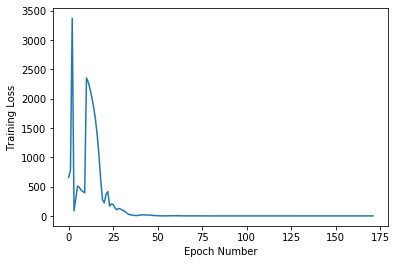

In [298]:
##Note: run cut off early and losses weren't saved. Instead copied loss values and saved to external text file for plotting 
loss = np.loadtxt("loss.txt")

import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(loss)

ax.set(xlabel='Epoch Number', ylabel='Training Loss')

plt.show()

Model trained for 171 epochs and final training loss of ~3.928 obtained for single phase SiO$_{2}$.  Illustrating that onset to convergence after 50 epochs.   

Now we train this model on the entre SiO$_{2}$ elasticty tensor dataset, utilizing the same hyperparamaters as in the training session above. Now trained for 50 epochs. 

In [296]:
def main():
    outs = []
    loss_values = [] 
    network = GatedConvParityNetwork(**model_kwargs)
    model = AggregateAtoms(network)
    torch.set_default_dtype(torch.float64)
    x_train = x_train_sio2 
    y_train = y_train_sio2
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss_func = torch.nn.MSELoss()
    iter = 0 
    for step in range(100):
        for i in range(len(x_train)):
            out = model(x_train[i].x, x_train[i].edge_index, x_train[i].edge_attr, n_norm=n_norm)
            outs.append(out.detach())
            loss = loss_func(out, y_train[i])
            loss_values.append(loss.item())
            print("iter: " +str(iter)+ " loss:" +str(loss.item()))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            iter += 1 
    return model, outs, loss_values


In [297]:
if __name__ == '__main__':
    model, outs,losses =  main()

iter: 0 loss:2535.2971783368944
iter: 1 loss:2508.7400939377326
iter: 2 loss:3009.116188267234
iter: 3 loss:2546.061995391515
iter: 4 loss:2618.1745965223186
iter: 5 loss:3240.9129446169773
iter: 6 loss:2527.0687863121175
iter: 7 loss:2269.6754061054357
iter: 8 loss:2511.989168853864
iter: 9 loss:2409.0938319868155
iter: 10 loss:2324.4812288863477
iter: 11 loss:2206.2676741101814
iter: 12 loss:2720.017142331436
iter: 13 loss:2571.0419397976975
iter: 14 loss:1821.19431718412
iter: 15 loss:13267.044696504743
iter: 16 loss:1601.4495317997312
iter: 17 loss:1829.2700038872822
iter: 18 loss:2373.135535614375
iter: 19 loss:2331.8993851494447
iter: 20 loss:2417.6431441398367
iter: 21 loss:2315.362030205736
iter: 22 loss:2585.6717992524987
iter: 23 loss:2066.8216266471395
iter: 24 loss:2385.287171387041
iter: 25 loss:2032.400854495943
iter: 26 loss:2586.5342003371975
iter: 27 loss:1205.8029974307804
iter: 28 loss:2936.052717105712
iter: 29 loss:1385.803213045488
iter: 30 loss:2239.7345567102557

KeyboardInterrupt: 